In [1]:
import numpy as np
import math
from functools import lru_cache
import matplotlib.pyplot as plt

# For reproducibility in Monte Carlo testing
rng = np.random.default_rng()


In [2]:
def build_polar_matrix(N: int) -> np.ndarray:
    """
    Construct the polar transform matrix G_N using Kronecker power.
    N must be a power of 2.
    Returns binary matrix (numpy int8).
    """
    assert (N & (N-1)) == 0, "N must be power of 2"
    G = np.array([[1, 0],
                  [1, 1]], dtype=np.int8)
    n = int(math.log2(N))
    for _ in range(n-1):
        G = np.kron(G, np.array([[1, 0],
                                [1, 1]], dtype=np.int8))
    return G % 2


In [3]:
def polar_encode_matrix(u: np.ndarray, G: np.ndarray) -> np.ndarray:
    """
    Encode using x = u G (mod 2).
    u and x are binary numpy vectors.
    G is NxN binary matrix.
    """
    x = (u @ G) % 2
    return x.astype(np.int8)


In [4]:
def f_llr(a, b):
    # Jacobian-log: sign(a)*sign(b)*min(|a|,|b|)
    return np.sign(a) * np.sign(b) * np.minimum(np.abs(a), np.abs(b))

def g_llr(a, b, u):
    # g = b*(1-2u) + a
    return b * ((-1) ** u) + a


In [5]:
def sc_decode_matrix(llr, frozen_mask):

    N = len(llr)

    def sc_recursive(llr_sub, frozen_sub):
        n = len(llr_sub)

        # Leaf
        if n == 1:
            if frozen_sub[0]:
                return np.array([0], dtype=np.int8)
            else:
                return np.array([0 if llr_sub[0] >= 0 else 1], dtype=np.int8)

        mid = n//2

        # Split
        a = llr_sub[:mid]
        b = llr_sub[mid:]

        # f
        f_vals = f_llr(a, b)
        u_up = sc_recursive(f_vals, frozen_sub[:mid])

        # g
        g_vals = g_llr(a, b, u_up)
        u_low = sc_recursive(g_vals, frozen_sub[mid:])

        # combine
        u = np.empty(n, dtype=np.int8)
        u[:mid] = (u_up ^ u_low)
        u[mid:] = u_low

        return u

    return sc_recursive(np.array(llr, dtype=float),
                        np.array(frozen_mask, dtype=bool))


In [6]:
@lru_cache(None)
def bhattacharyya_bounds(N, p):
    """
    Returns array Z such that Z[i] is the estimated reliability
    of bit-channel i under the polarization transform.
    """
    if N == 1:
        return np.array([math.sqrt(4 * p * (1 - p))])

    Z_half = bhattacharyya_bounds(N // 2, p)

    Z = np.empty(N)
    for i in range(N // 2):
        z = Z_half[i]
        Z[i] = 2*z - z*z        # "bad" channel
        Z[i + N//2] = z*z      # "good" channel

    return Z


In [7]:
def construct_frozen_mask(N, K, p_design=0.05):
    """
    Build frozen mask for SC using Bhattacharyya reliability estimates.
    Returns:
      frozen_mask (bool array)
      info_positions (indices of unfrozen bits)
    """

    Z = bhattacharyya_bounds(N, p_design)
    ordering = np.argsort(Z)

    info_positions = np.sort(ordering[:K])
    frozen_mask = np.ones(N, dtype=bool)
    frozen_mask[info_positions] = False

    return frozen_mask, info_positions


In [8]:
def noiseless_test(N=4, K=2, p_design=0.05):

    G = build_polar_matrix(N)
    frozen_mask, info_positions = construct_frozen_mask(N, K, p_design)

    # Pick data in info positions
    u = np.zeros(N, dtype=np.int8)
    u[info_positions] = rng.integers(0, 2, size=K, dtype=np.int8)

    # Encode
    x = polar_encode_matrix(u, G)

    # Convert bits to LLRs as if perfectly received BSC
    L = 27.63102111592755  # big positive number to simulate "infinite reliability"
    llr = np.where(x == 0, L, -L)

    # Decode
    uhat = sc_decode_matrix(llr, frozen_mask)

    ok = np.all(uhat == u)
    return ok, u, uhat, info_positions, frozen_mask


In [9]:
def monte_carlo_polar_matrix(N, K, p_channel=0.05, trials=500):

    G = build_polar_matrix(N)
    frozen_mask, info_positions = construct_frozen_mask(N, K, p_channel)

    bit_err = 0
    blk_err = 0
    total_bits = trials * K

    for _ in range(trials):

        # random info bits
        u = np.zeros(N, dtype=np.int8)
        u[info_positions] = rng.integers(0, 2, size=K)

        # encode
        x = polar_encode_matrix(u, G)

        # BSC noise
        noise = rng.integers(0, 2, size=N)
        y = x ^ noise

        # build LLRs for BSC(y | x, p)
        L = math.log((1 - p_channel) / p_channel)
        llr = np.where(y == 0, L, -L)

        # decode
        uhat = sc_decode_matrix(llr, frozen_mask)

        # count errors only in info bits
        diff = (u[info_positions] != uhat[info_positions])

        bit_err += np.sum(diff)
        if np.any(diff):
            blk_err += 1

    return bit_err / total_bits, blk_err / trials


In [10]:
N = 128
K = 64
p = 0.05

ber, fer = monte_carlo_polar_matrix(N, K, p_channel=p, trials=200)
print("BER:", ber, "FER:", fer)


BER: 0.498359375 FER: 1.0


In [11]:
def sweep_plot():
    ps = np.linspace(0.01, 0.15, 8)
    bers = []
    fers = []

    for p in ps:
        ber, fer = monte_carlo_polar_matrix(128, 64, p_channel=p, trials=300)
        bers.append(ber)
        fers.append(fer)
        print(p, ber, fer)

    plt.figure()
    plt.plot(ps, bers, marker='o')
    plt.plot(ps, fers, marker='x')
    plt.xlabel("p (BSC)")
    plt.ylabel("Error rate")
    plt.grid(True)
    plt.legend(["BER","FER"])


0.01 0.5022916666666667 1.0
0.03 0.49932291666666667 1.0
0.049999999999999996 0.5040625 1.0
0.06999999999999999 0.49703125 1.0
0.08999999999999998 0.5028645833333333 1.0
0.10999999999999997 0.50625 1.0
0.12999999999999998 0.49635416666666665 1.0
0.15 0.4990104166666667 1.0


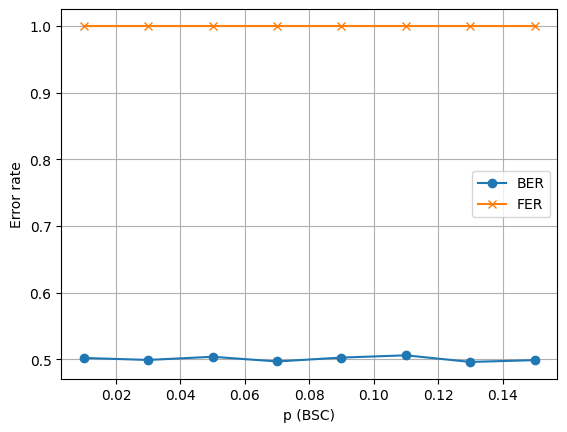

In [12]:
sweep_plot()